# AI EU Project #

In [3]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_excel('pstw_dataset.xlsx')

## Drop unnused columns ##

In [4]:
# Ensures all the projects are within AI 
df = df[df['Primary Technology'].str.lower() == 'artificial intelligence']

# Replaces Pilot phase with pilot for consistensy
df[' Status'] = df[' Status'].replace({'Pilot phase': 'Pilot'})

# This will be the hyperparameter used when modelling
df_y = df[' Status']

# Resets the indexing so that it will match the other data when modelling
df_y = df_y.reset_index(drop=True)

# All columns needed for the project
columns = [
    "Geographical extent",
    "Functions of Government (COFOG level I)",
    "Functions of Government (COFOG level II)",
    "Process type",
    "Application type",
    "Cross Border",
    "Cross Sector",
    "Interaction",
    "Increase quality of PSI and services",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    "AI Classification (I)",
    "AI Classification Subdomain (II) (main)",
    "AI Classification Subdomain (II) (Other I)",
    "AI Keywords",
    "Collaboration type",
    "Funding source"
]

# Columns to replace that contains X:s
x_columns = [
    # "Improved Public Service",
    # "Personalized Services",
    # "Public (citizen)-centered services",
    "Increase quality of PSI and services",
    # "More responsive, efficient, and cost-effective public services",
    # "New services or channels",
    # "Improved Administrative Efficiency",
    # "Cost-reduction",
    # "Responsiveness of government operation",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    # "Open government capabilities",
    # "Increased transparency of public sector operations"
]

# Selects the right columns
df_selected = df[columns]

# Replaces X/ x with 1 or 0 to ease dummy-encoding
def translate_x(dataFrame, column):
  dataFrame[column] = dataFrame[column].replace({
      "x": 1,
      "X": 1,
      "\xa0": 0,
      np.nan: 0
  })
  dataFrame[column] = dataFrame[column].astype(int)

# Translates X in for the right columns
for column in x_columns:
    translate_x(df_selected, column)

# Dummy encoding
df_oh = pd.get_dummies(df_selected, dtype=int)

# Resets the index so that it will match when modelling
df_oh = df_oh.reset_index(drop=True)

print(df_oh.info())
print(df_y.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Columns: 264 entries, Increase quality of PSI and services to Funding source_Regional-funded project
dtypes: int64(264)
memory usage: 3.2 MB
None
['Not in use' 'Implemented' 'Pilot' 'Planned' 'In development']


/tmp/ipykernel_1141638/2116518268.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataFrame[column] = dataFrame[column].replace({
/tmp/ipykernel_1141638/2116518268.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame[column] = dataFrame[column].replace({
/tmp/ipykernel_1141638/2116518268.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [5]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal encoding for the target variable
# df_oe = pd.DataFrame()
encoder = OrdinalEncoder()
df_oe = pd.DataFrame(encoder.fit_transform(df_selected), columns=df_selected.columns)
# df_oe = df_oe.astype(int)

print(df_oe)



      Geographical extent  Functions of Government (COFOG level I)  \
0                     3.0                                      9.0   
1                     3.0                                      4.0   
2                     3.0                                      3.0   
3                     5.0                                      1.0   
4                     2.0                                      4.0   
...                   ...                                      ...   
1570                  2.0                                     10.0   
1571                  3.0                                      4.0   
1572                  2.0                                      4.0   
1573                  3.0                                      9.0   
1574                  3.0                                      9.0   

      Functions of Government (COFOG level II)  Process type  \
0                                         56.0           4.0   
1                              

Index(['Increase quality of PSI and services',
       'Improved management of public resources',
       'Increased quality of processes and systems',
       'Geographical extent_Across Countries',
       'Geographical extent_Across countries', 'Geographical extent_Local',
       'Geographical extent_National', 'Geographical extent_National ',
       'Geographical extent_Regional', 'Geographical extent_Regional ',
       ...
       'Collaboration type_Other PAs',
       'Collaboration type_Private corporation',
       'Collaboration type_Sandboxing', 'Collaboration type_Universities',
       'Collaboration type_Universities/Research organisations',
       'Funding source_EU-funded project',
       'Funding source_Funded with own resources',
       'Funding source_Local-funded project',
       'Funding source_National-funded project',
       'Funding source_Regional-funded project'],
      dtype='object', length=264)


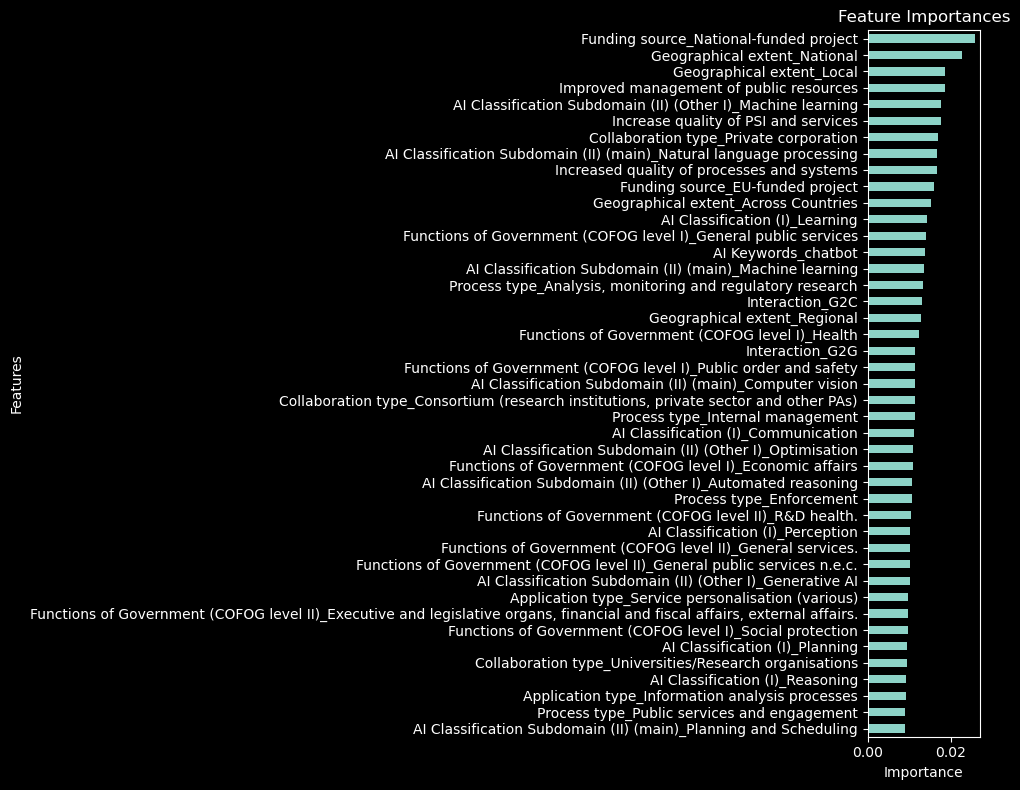

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Label encoding y-data
le = LabelEncoder()
y_encoded = le.fit_transform(df_y)

# Assigning data to variables
y = y_encoded
X = df_oh

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.2, stratify=y_train_val)

# Scaling data
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)


rm_model = RandomForestClassifier()

rm_model.fit(X_train, y_train)

importances = rm_model.feature_importances_
feature_names = X.columns

print(feature_names)
feat_df = pd.DataFrame({
  'Feature': feature_names,
  'Importance': importances
})

filtered_df = feat_df[feat_df['Importance'] > 0.009]

filtered_df = filtered_df.sort_values(by='Importance', ascending=True)

# print(importances)

filtered_df.plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(10, 8)
)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

plt.show() 

Classes in y_val: [0 1 2 3 4]
Index(['Geographical extent', 'Functions of Government (COFOG level I)',
       'Functions of Government (COFOG level II)', 'Process type',
       'Application type', 'Cross Border', 'Cross Sector', 'Interaction',
       'Increase quality of PSI and services',
       'Improved management of public resources',
       'Increased quality of processes and systems', 'AI Classification (I)',
       'AI Classification Subdomain (II) (main)',
       'AI Classification Subdomain (II) (Other I)', 'AI Keywords',
       'Collaboration type', 'Funding source'],
      dtype='object')
[0.07940556 0.07975177 0.1277996  0.04560225 0.09827942 0.01716524
 0.01841541 0.03161484 0.02497284 0.02678978 0.02566693 0.06635114
 0.07164299 0.10456257 0.07476354 0.06093049 0.04628562]


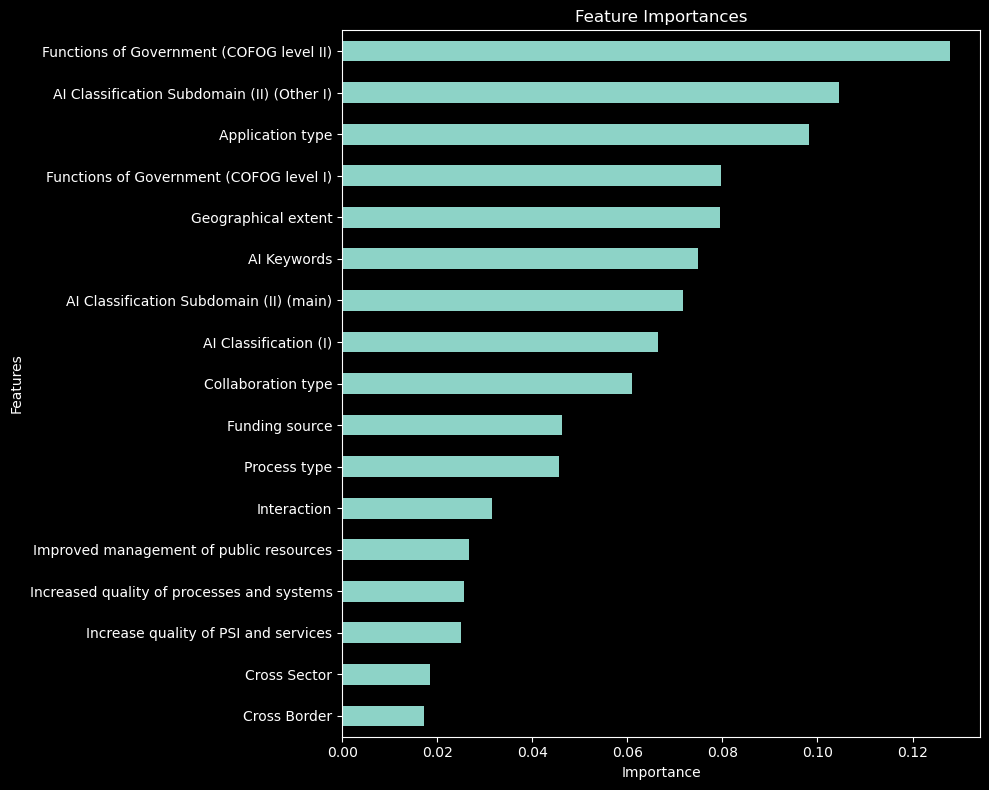

In [7]:
y_fi = y_encoded
X_fi = df_oe

X_train_val_fi, X_test_fi, y_train_val_fi, y_test_fi = train_test_split(X_fi, y_fi, random_state=42, test_size=0.2)
X_train_fi, X_val_fi, y_train_fi, y_val_fi = train_test_split(X_train_val_fi, y_train_val_fi, random_state=42, test_size=0.2) 

print("Classes in y_val:", np.unique(y_val_fi))


X_train_fi = scaler.fit_transform(X_train_fi)
X_val_fi = scaler.fit_transform(X_val_fi) 
X_test_fi = scaler.fit_transform(X_test_fi)

rm_model.fit(X_train_fi, y_train_fi)

importances = rm_model.feature_importances_
feature_names = X_fi.columns

print(feature_names)
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    })

filtered_df = feat_df
filtered_df = filtered_df.sort_values(by='Importance', ascending=True)
print(importances)

filtered_df.plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(10, 8)
)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svc = SVC()
rm_cl = RandomForestClassifier(random_state=42)
et_cl = ExtraTreesClassifier(random_state=42)

hypergrid_svc = {
  'kernel': ['rbf', 'poly', 'sigmoid'],
  'C': [0.1, 1, 10],
  'gamma': [0.01, 0.1, 0.5, 1]
}

hypergrid_rm = {
  'n_estimators': [10, 50, 100, 150],
  'min_samples_split': [2, 5, 10]
}

svc_model_gs = GridSearchCV(svc, hypergrid_svc, scoring='balanced_accuracy')
rm_model_gs = GridSearchCV(rm_cl, hypergrid_rm, scoring='balanced_accuracy')
et_model_gs = GridSearchCV(et_cl, hypergrid_rm, scoring='balanced_accuracy')

models_score = []

for clf in (svc_model_gs, rm_model_gs, et_model_gs):
  # Predikterar på valideringsdata och tränar modellerna 
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Skriver ut scoring för accuracy, precision, recall och f1
  prec_score = precision_score(y_test, y_pred, average='macro', zero_division=0)
  print(f'\n{clf.best_estimator_}', '\nAccuracy score:', accuracy_score(y_test, y_pred), 
        '\nPrecision score:', prec_score,
        '\nRecall score:', recall_score(y_test, y_pred, average='macro', zero_division=0),
        '\nF1 score:', f1_score(y_test, y_pred, average='macro', zero_division=0)
  )

  models_score.append({
        'model': clf,
        'score': prec_score
  })

# Sparar den bästa modellen
best_prec_model = max(models_score, key=lambda x: x['score'])
print(f'\nBest model score: {best_prec_model['score']}')
best_model = best_prec_model['model']


SVC(C=0.1, gamma=0.1, kernel='poly') 
Accuracy score: 0.526984126984127 
Precision score: 0.25938261046174715 
Recall score: 0.25888520655962516 
F1 score: 0.2586664615068985

RandomForestClassifier(n_estimators=50, random_state=42) 
Accuracy score: 0.5650793650793651 
Precision score: 0.28083916083916083 
Recall score: 0.2709892768032303 
F1 score: 0.2694474690435795

ExtraTreesClassifier(random_state=42) 
Accuracy score: 0.5746031746031746 
Precision score: 0.3259912070343725 
Recall score: 0.31820219796963983 
F1 score: 0.3189347380743342

Best model score: 0.3259912070343725


In [9]:
# bästa modellen tränas om på train och val
best_model = best_model.fit(X_train_val, y_train_val)

#modell testas på testdata
bm_test_pred = best_model.predict(X_test)

print(f"\n{best_model.best_estimator_}", "\nAccuracy score:", accuracy_score(y_test, bm_test_pred),
      "\nPrecision score:", precision_score(y_test, bm_test_pred, average='macro', zero_division=0),
      "\nRecall score:", recall_score(y_test, bm_test_pred, average='macro', zero_division=0),
      "\nF1 score:", f1_score(y_test, bm_test_pred, average='macro', zero_division=0))


ExtraTreesClassifier(n_estimators=50, random_state=42) 
Accuracy score: 0.5777777777777777 
Precision score: 0.33322294831037325 
Recall score: 0.3401043749880959 
F1 score: 0.3346930846930847


In [14]:
import joblib

#modell tränas på hela datasetet
X = df_oh
y = y_encoded
X = scaler.fit_transform(X)
best_model = best_model.fit(X, y)

joblib.dump(best_model, 'best_model.pkl')
joblib.dump(df_oh, "features.pkl")
joblib.dump(y_encoded, "targets.pkl")

['targets.pkl']